# Analyzing the ISL/OSL of the Shopify Global Catalogue Dataset

In [13]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import pprint
from mlperf_inference_multimodal_vl2l.task import ShopifyGlobalCatalogue

In [ ]:
dataset = load_dataset("Shopify/the-catalogue-public-beta", token="...")

Total number of products: 239
An example product at index 5:
title: Custom Neon: Pret á Pilates
description: Text: Pret á Pilates<br>
      Text Align: Center<br>Font: Hesterica<br>Color: Pink<br>Size: 100cm wide / 100cm X 25.73cm / 39.37in X 10.13in<br>Backboard: Cut to Letter (free upgrade)<br>Jacket: Coloured Jacket<br>Mounting: Wall mounting screws<br>Add a Heart or Star (Optional): None (Default)<br>Neon Tube Thickness: Classic Tube (6mm)<br>Remote Dimmer: Yes<br>Power Mode: Power Adaptor<br>Splashproofing: No<br>
category: Business & Industrial > Signage > Electric Signs > Neon Signs
brands: ["crafty neon signs"]
standardized_title: Crafty Neon Signs Pret á Pilates Custom Neon Sign
standardized_description: The Crafty Neon Signs Pret á Pilates Custom Neon Sign is a stylish and personalized addition to any space. Perfect for adding a unique touch to your home or studio.

- **Key Features:**
  - Text: Pret á Pilates, aligned center
  - Font: Hesterica, Color: Pink
  - Size: 100cm w

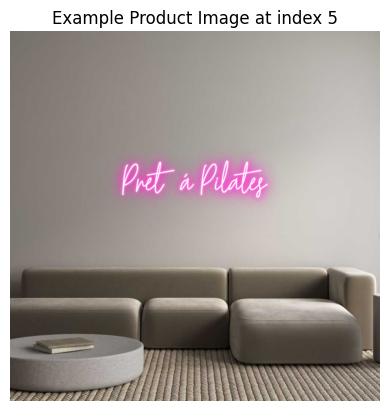

image_base64_string='iVBORw0KGgoAAAANSUhEUgAAA+gAAAPoCAIAAADCwUOzAAABCmlDQ1BJQ0MgUHJvZmlsZQAAeJxjYGBckZOcW8wkwMCQm1dSFOTupBARGaXAfoeBkUGSgZlBk8EyMbm4wDEgwIcBJ/h2DagaCC7rgszCrQ4r4ExJLU4G0h+AOD65oKiEgYERZBdPeUkBiB0BZIsUAR0FZOeA2OkQdgOInQRhTwGrCQlyBrJ5gGyHdCR2EhIbahcIsCYbJWciOyS5tKgMypQC4tOMJ5mTWSdxZHN/E7AXDZQ2UfyoOcFIwnqSG2tgeezb7IIq1s6Ns2rWZO6vvXz4pcH//yWpFSUgzc7OBgygMEQPG4RY/iIGBouvDAzMExBiSTMZGLa3MjBI3EKIqSxgYOBvYWDYdh4A8P1N247YzPkAAQAASURBVHic7P3bkyRLdt6Lfd/yyKyqrup77+vsmQEGwADDAxAEL4dG05FEs3ORSe960J+gN5npf9PLkfTAw0MIBoI8IAkQBAjMBTN79rV33+uS4WvpYblHRGZlVldWZ1VmVK8fwT3VmZEeHh4emZ8vX/45/5//j/871oEkyes7fl1okLWOv+76vE/lKwBZsz8YgCW37Lqva112rp9vqPxrLUcBW7Nsy8rSiUjSKiIisthNFDAAG2rm8+VHOddRzrbOu61yttVu5yvgD9RbD7smxvKVuK3y1zqvqt58TTbIBfVfq5391+Hdy7lC+ddazqrjV72+5a+YIAiCIAiCIAguQwj3IAiCIAiCIBgBzbYrEARBEARBENxONph0tFMptdsihHsQBEEQBEFwLWxKbYdqdyJVJgiCIAiCIAhGQETcgyAIgiAIgutiabD8ChYuq4LuG3GDGQs3IdwvsO+5gbMHQRAEQRAEW+S85Lua2t5UOeOluW71vC3VHuVvtpzbyg62z65V6Vq7oqSEQcbedXgnr1vgWB7tTTH2r5qx138VGzGl3kg
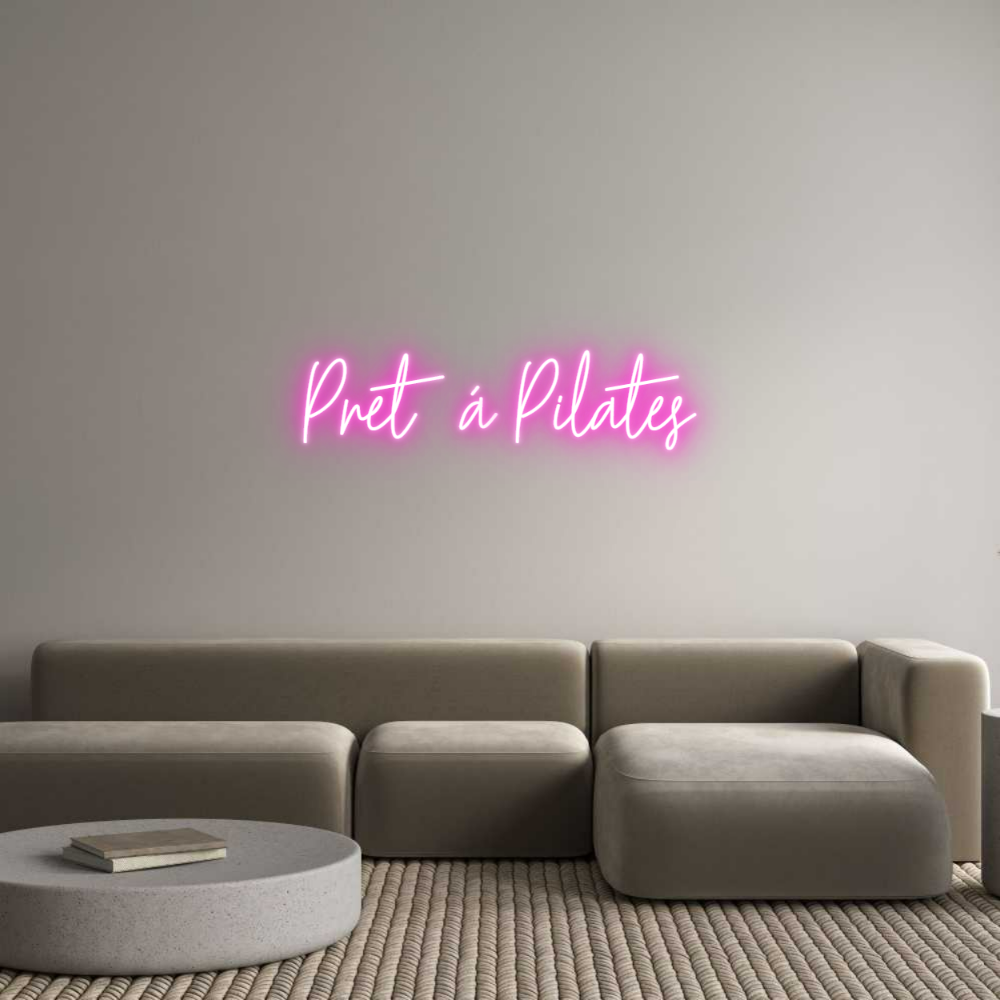

In [16]:
print(f"Total number of products: {len(dataset['train'])}")
example_index = 5
print(f"An example product at index {example_index}:")
for key, value in dataset["train"][example_index].items():
    print(f"==========\n{key}: {value}")

plt.imshow(dataset["train"][example_index]["image"])
plt.axis('off')
plt.title(f"Example Product Image at index {example_index}")
plt.show()

image_file = BytesIO()
dataset["train"][example_index]["image"].save(image_file, format="PNG")
image_bytes = image_file.getvalue()
image_base64 = base64.b64encode(image_bytes)
image_base64_string = image_base64.decode('utf-8')
print(f"{image_base64_string=}")

messages = ShopifyGlobalCatalogue.formulate_messages(dataset['train'][example_index])
print("Example prompt (messages):")
pprint.pprint(messages)

In [4]:

def count_and_plot_top_n(dataset, value_fn, field_label, n=10):
    """
    Counts occurrences using a custom value extraction function.

    Args:
        dataset: A split of the HuggingFace dataset as returned by load_dataset.
        value_fn: A function (product_dict) -> value, to extract the field to be counted.
        field_label: String label to describe the field when printing (default: function name or 'field').
        n: Number of top frequent items to print.
    """
    values = [value_fn(product) for product in dataset]
    # Remove Nones (missing values)
    values = [v for v in values if v is not None]
    counts = Counter(values)
    top_n = counts.most_common(n)
    import matplotlib.pyplot as plt

    # Use only the top n keys and their counts for the histogram
    keys = [key for key, _ in top_n]
    values = [count for _, count in top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), values, tick_label=[str(k) for k in keys])
    plt.title(f"Top {n} {field_label}s")
    plt.xlabel(f"{field_label.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    assert counts.total() == len(dataset), f"Counts total {counts.total()} does not match dataset length {len(dataset)}"

/tmp/ipykernel_3458284/1493303669.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


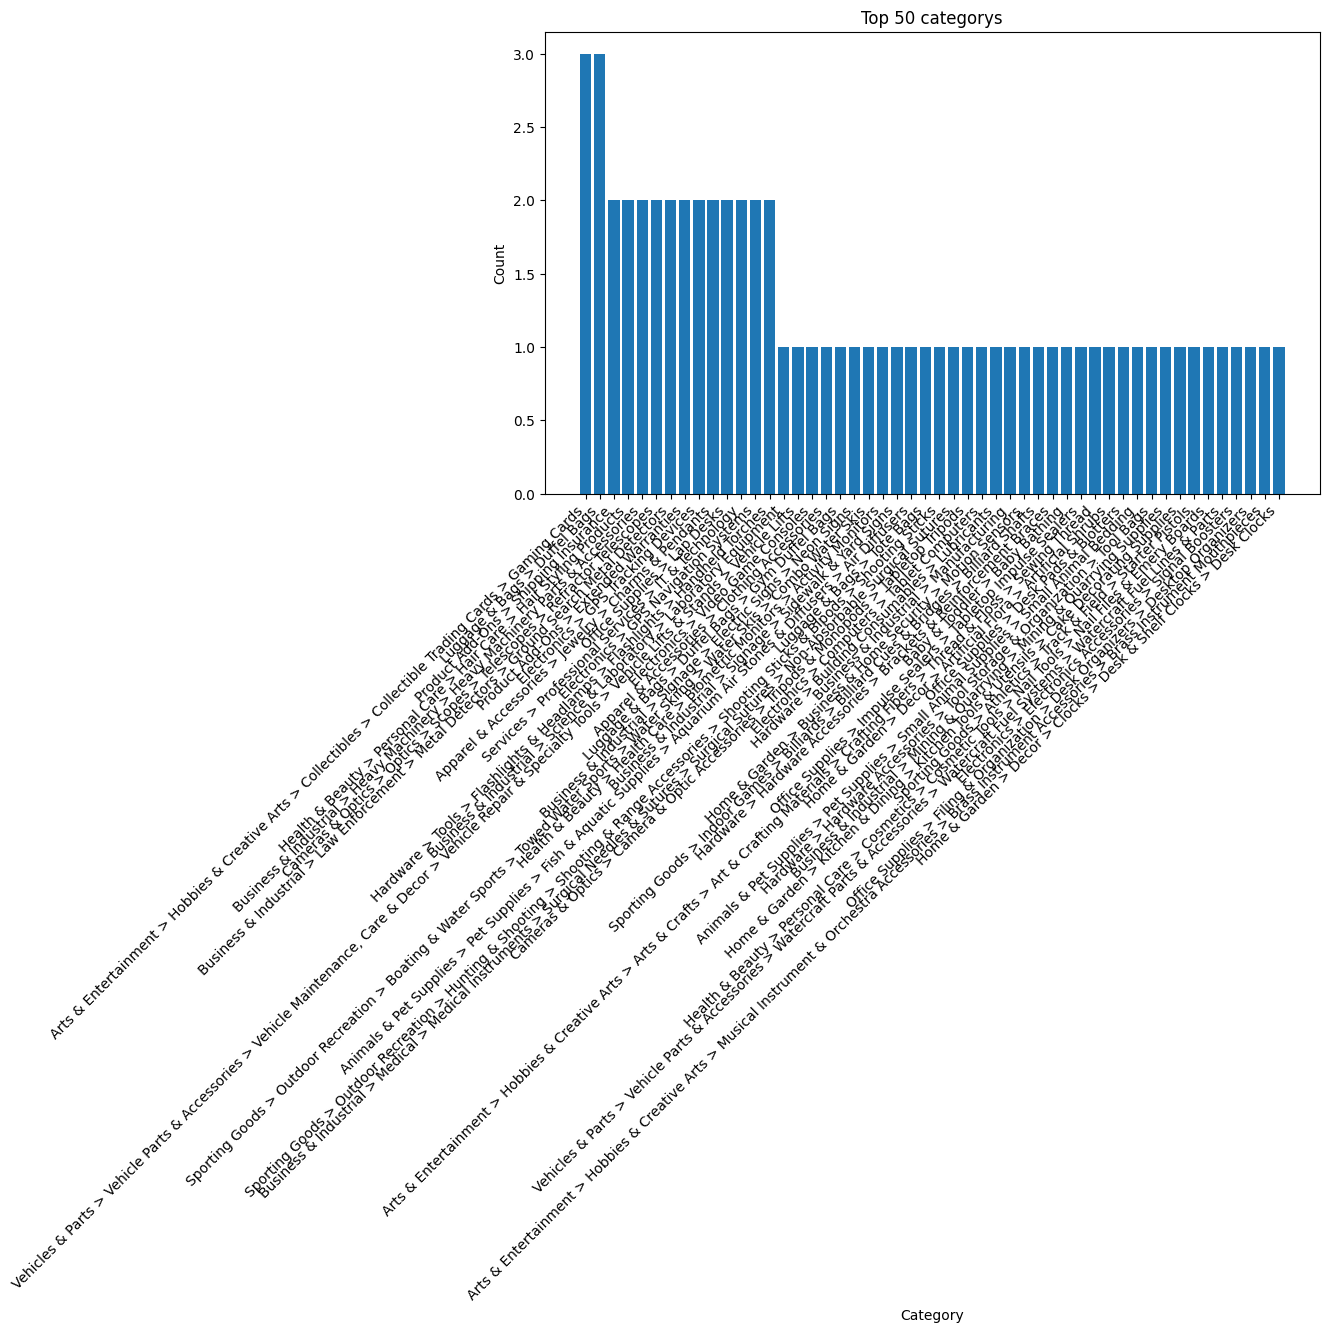

In [5]:
count_and_plot_top_n(dataset["train"], lambda p: p.get('category'), field_label='category', n=50)

There seems to be a lot of unique catagories. The VLM doesn't know the entire list of catagories to choose from.

Potential solutions are:
1. Passing the entire list of catagories as part of the system prompt to the VLM. 
   However, this would make the system prompt too long.
2. From K: Do some sort of semantic similarity search and return a list of 20 or so 
   categories and then ask the VLM to pick one. Shopify already plan on doing this,
   since it would decouple the model from changes to the taxonomy.

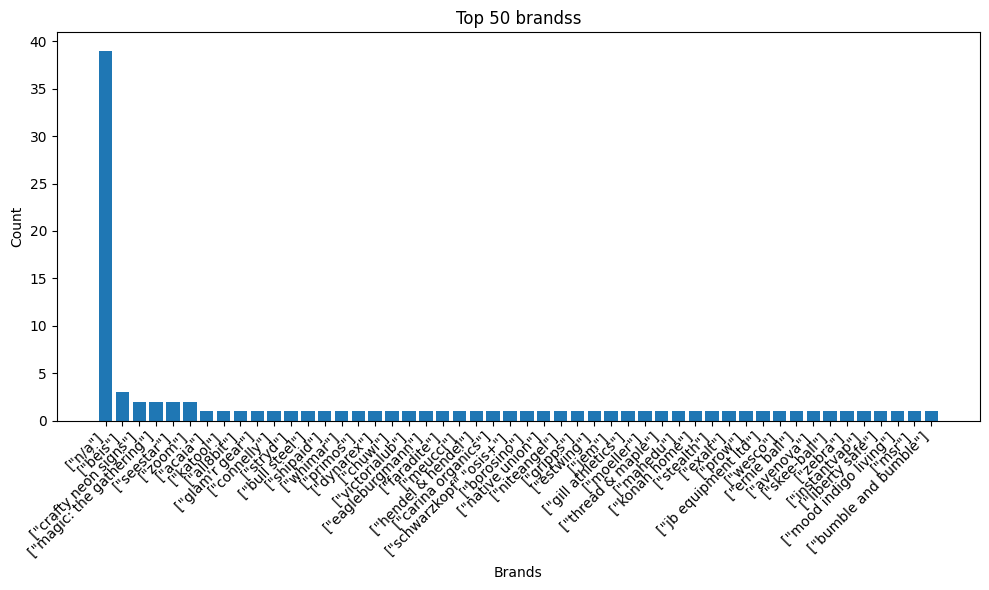

In [6]:
count_and_plot_top_n(dataset["train"], lambda p: p.get('brands'), field_label='brands', n=50)

Similar issues with brands. There seems to be a lot of unique brands.

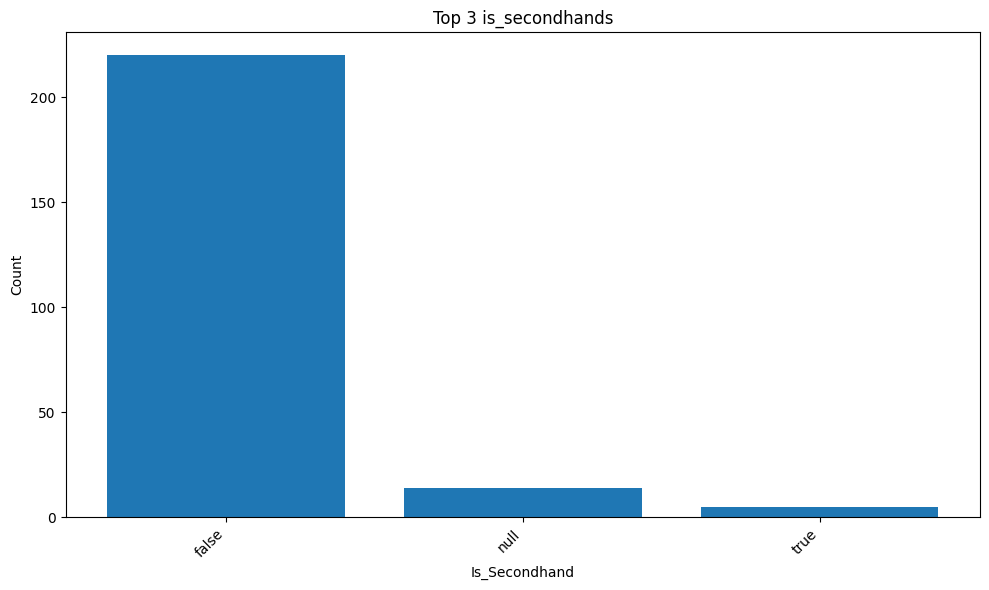

In [7]:
count_and_plot_top_n(dataset["train"], lambda p: p.get('is_secondhand'), field_label='is_secondhand', n=3)

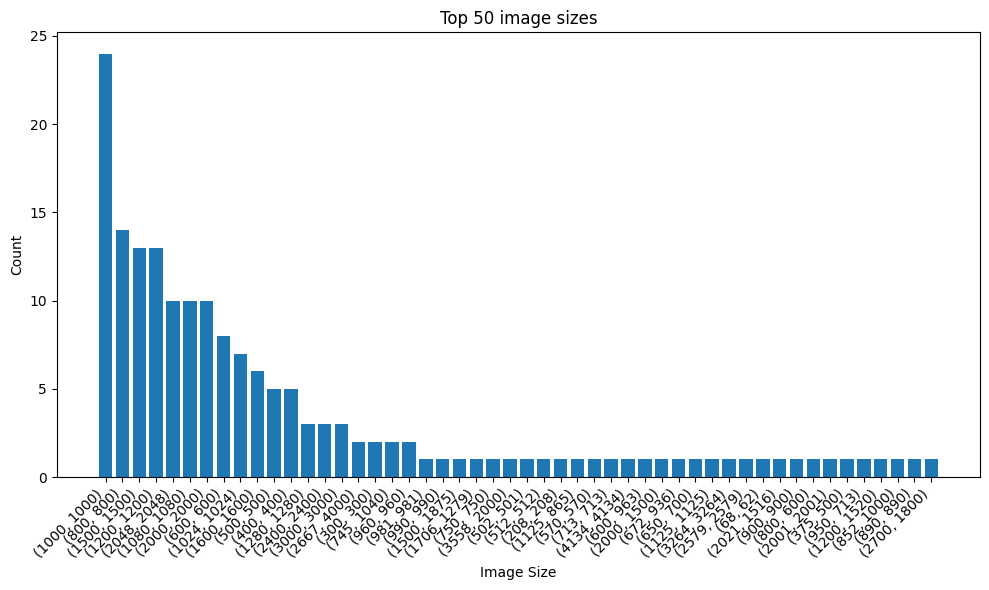

In [8]:
count_and_plot_top_n(dataset["train"], lambda p: (p.get('image').width, p.get('image').height), field_label='image size', n=50)

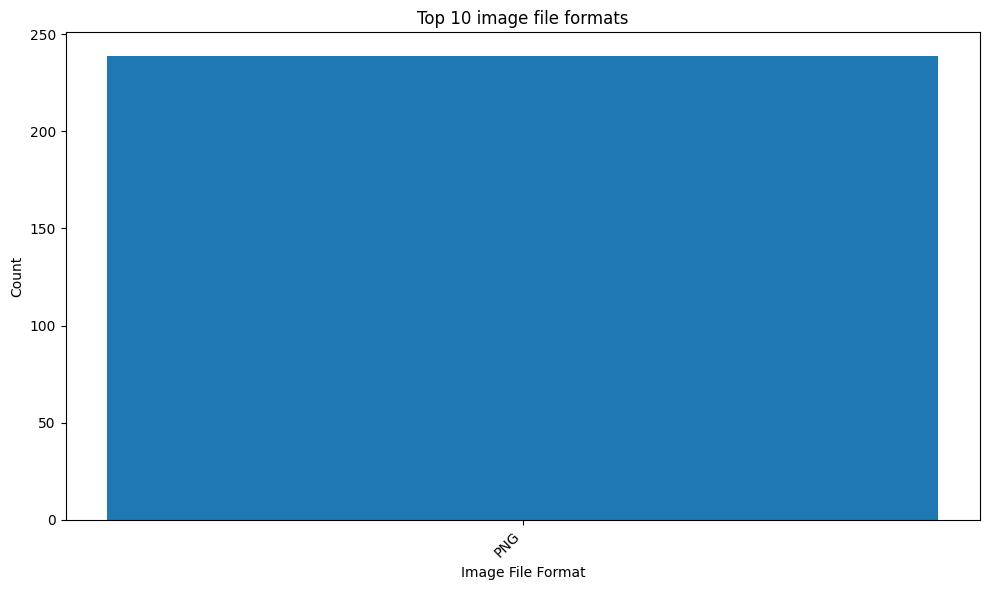

In [9]:
count_and_plot_top_n(dataset["train"], lambda p: p['image'].format, field_label='image file format', n=10)